# Using Earth Access to Build and image

The goal is to use Earth Access to 

- load the rasters that cover Madison
- process them
- merge (or mosaic) them into one image

This is a reworking of 
[92-bulk-download](https://github.com/earthlab-education/fundamentals-04-redlining-byandell/blob/main/notebooks/redlining-92-bulk-download.ipynb).

In [1]:
city = "Madison"

In [ ]:

import pandas as pd # Group and aggregate
import numpy as np # Process bit-wise cloud mask
import rioxarray as rxr # Work with raster data
from rioxarray.merge import merge_arrays # Merge rasters

In [4]:
pip install ~/Documents/GitHub/landmapy

Processing /Users/brianyandell/Documents/GitHub/landmapy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for landmapy: filename=landmapy-0.1-py3-none-any.whl size=18371 sha256=cd87b2624193b5b53a03fc3217d0f6eeadab8b766c21f9bd741a44af51103e7a
  Stored in directory: /private/var/folders/tt/cyd1sy9s18l1fgc_0ty8l91w0000gn/T/pip-ephem-wheel-cache-h5tbh_tu/wheels/d4/8b/49/f05ffe83c93ff1cc194a4161d132e5ba0632f5ae288edbcd13
Successfully built landmapy
  Attempting uninstall: landmapy
    Found existing installation: landmapy 0.1
    Uninstalling landmapy-0.1:
      Successfully uninstalled landmapy-0.1
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os # Interoperable file paths
import pathlib # Find the home folder

In [5]:
# Define and create the project data directory
data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'redlining'
)
os.makedirs(data_dir, exist_ok=True)
data_dir

'/Users/brianyandell/earth-analytics/data/redlining'

## Site Map

In [6]:
import landmapy
from landmapy.redline import redline_gdf, plot_redline

/Users/brianyandell/miniconda3/envs/earth-analytics-python/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/brianyandell/earth-analytics/data/redlining/redlining/redlining.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


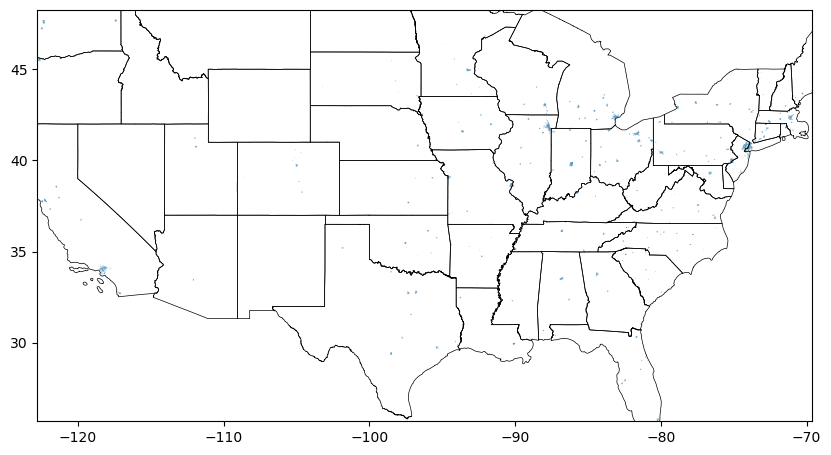

In [8]:
redlining_gdf = redline_gdf(data_dir)
plot_redline(redlining_gdf)

<Axes: >

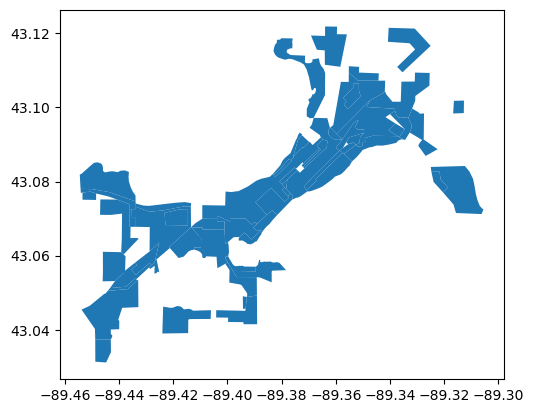

In [9]:
city_redlining_gdf = redlining_gdf[redlining_gdf.city == city]
city_redlining_gdf.plot()

## Select EarthAccess Images

The goal is to use Earth Access to

1. load the rasters that cover selected `city`,
2. process them, and 
3. merge (or mosaic) them into one image

Search for the `city` data and create file connections `city_files`.

In [ ]:
%store -r city_files
try:
    city_files
except NameError:
    import earthaccess # Access NASA data from the cloud
    
    # `city_files` does not yet exist
    earthaccess.login(strategy="interactive", persist=True)
    # Search earthaccess
    city_results = earthaccess.search_data(
        short_name="HLSL30",
        bounding_box=tuple(city_redlining_gdf.total_bounds),
        temporal=("2023-07-12", "2023-07-13"),
        count=1)
    city_files = earthaccess.open(city_results)
    %store city_files
    print("city_files created and stored")
else:
    print("city_files already exists")


city_files already exists


## Process EarthAccess Images

In [72]:
from landmapy.process import process_image, process_metadata, process_cloud_mask, process_bands

In [73]:
raster_df = process_metadata(city_files)

# Check the results
raster_df.head()

,tile_id,date,band_id,file
0,T16TCN,2023194,SAA,"<File-like object HTTPFileSystem, https://data..."
1,T16TCN,2023194,B11,"<File-like object HTTPFileSystem, https://data..."
2,T16TCN,2023194,B01,"<File-like object HTTPFileSystem, https://data..."
3,T16TCN,2023194,VZA,"<File-like object HTTPFileSystem, https://data..."
4,T16TCN,2023194,B09,"<File-like object HTTPFileSystem, https://data..."


In [76]:
del city_das

In [78]:
%store -r city_das
try:
    city_das
except NameError:
    city_das = process_bands(city_redlining_gdf, raster_df)
    %store city_das
    print("city_das created and stored")
else:
    print("city_das already stored")

city_das already stored


There are large parts of the area that are missing. I could not find another date with better imaging,
probably because `city` Madison is so small on image, and it has five lakes.
A couple things I would like to be able to do:

- Show plot from `raster_df` to show something like image seen on NASA HLS30.
- Outline the lakes.
- Convert to CRS `EPSG:4326`

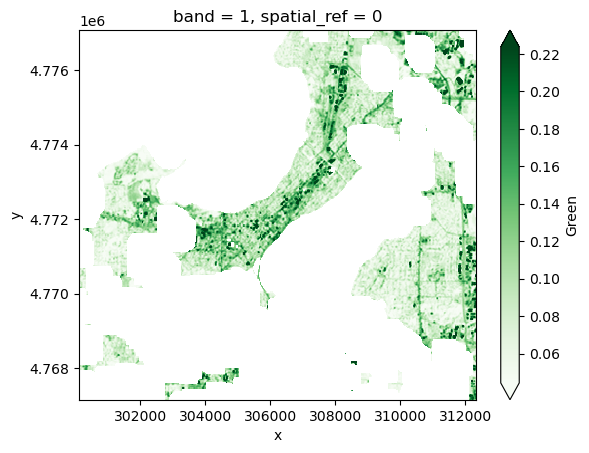

In [79]:
city_das['green'].rio.write_crs("EPSG:4326").plot(cmap='Greens', robust=True)

## NDVI

NDVI compares the amount of NIR reflectance to the amount of Red reflectance, thus accounting for many of the species differences and isolating the health of the plant.


In [ ]:
def plot_index(city_ndvi_da, city):
    """Plot Index."""
    import matplotlib.pyplot as plt # Overlay raster and vector data
    #Plot the ndvi_da to see CRS
    city_ndvi_da.plot(
        cbar_kwargs={"label": "NDVI"},
        robust=True)
    plt.gca().set(
        title = city + ' NDVI',
        xlabel='',
        ylabel='')
    plt.show()

# plot_index(city_ndvi_da, city)

In [88]:
city_ndvi_da = (
    (city_das['nir'] - city_das['red']) / (city_das['nir'] + city_das['red'])
)

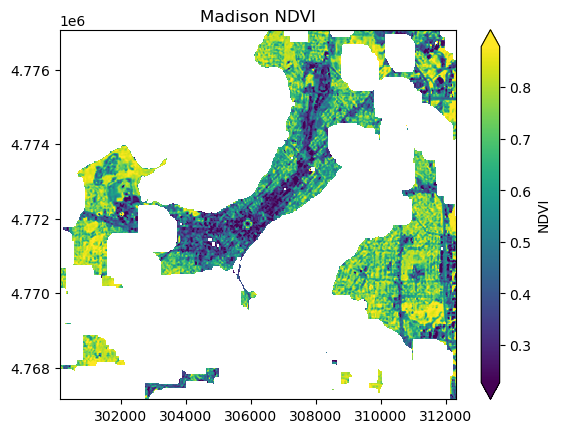

In [82]:
plot_index(city_ndvi_da, city)

Overlay redlining grades on NDVI map.

In [ ]:
def redline_over_index(city_redlining_gdf, city_ndvi_da):
    """Overlay redlining grades on NDVI map."""
    import cartopy.crs as ccrs # CRSs
    import matplotlib.pyplot as plt # Overlay raster and vector data

    city_plot_gdf = city_redlining_gdf.to_crs(ccrs.Mercator())
    ndvi_plot_da = city_ndvi_da.rio.reproject(ccrs.Mercator())

    ndvi_plot_da.plot(vmin=0, robust=True)
    city_plot_gdf.plot(ax=plt.gca(), color='none')
    plt.gca().set(
        xlabel='', ylabel='', xticks=[], yticks=[])
    plt.show()

# redline_over_index(city_redlining_gdf, city_ndvi_da)

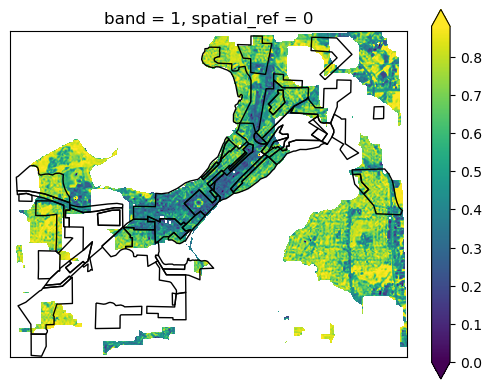

In [90]:
redline_over_index(city_redlining_gdf, city_ndvi_da)

## Zonal Statistics

In [ ]:
def redline_mask(city_redlining_gdf, city_ndvi_da):
    """Define new variable for denver redlining mask, using regionmask."""
    import regionmask # Convert shapefile to mask
    redlining_mask = regionmask.mask_geopandas(
        # Put gdf in same CRS as raster
        city_redlining_gdf.to_crs(city_ndvi_da.rio.crs),
        # x and y coordinates from raster data x=504 y=447
        city_ndvi_da.x, city_ndvi_da.y,
        # The regions do not overlap
        overlap=False,
        # We're not using geographic coordinates
        wrap_lon=False)

# redlining_mask = redline_mask(city_redlining_gdf, city_ndvi_da)

In [ ]:
redlining_mask = redline_mask(city_redlining_gdf, city_ndvi_da)

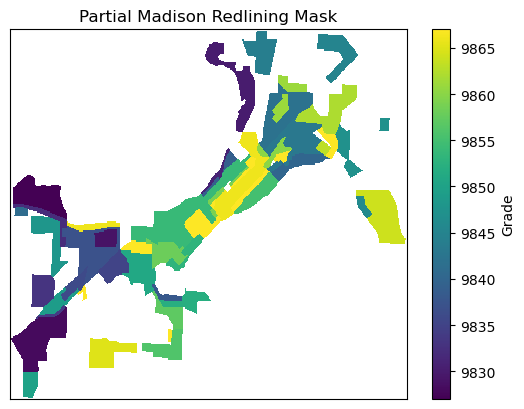

In [ ]:
# Plot the redlining mask 
redlining_mask.plot(cbar_kwargs={"label": "Grade"})

import matplotlib.pyplot as plt # Make subplots

plt.gca().set(title = 'Partial ' + city + ' Redlining Mask', 
    xlabel='', ylabel='', xticks=[], yticks=[])
plt.show()

In [ ]:
from xrspatial import zonal_stats # Calculate zonal statistics

# Calculate NDVI stats for each redlining zone
ndvi_stats = zonal_stats(redlining_mask, city_ndvi_da)

# Call denver_ndvi_states to see the table
ndvi_stats.head()

,zone,mean,max,min,sum,std,var,count
0,9827.0,0.728887,0.969571,0.315103,500.016632,0.096498,0.009312,686.0
1,9828.0,0.772770,0.919229,0.483455,327.654419,0.073992,0.005475,424.0
2,9829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9830.0,0.703321,0.903301,0.312640,789.829224,0.094096,0.008854,1123.0
4,9831.0,0.612807,0.772392,0.308735,71.698364,0.090015,0.008103,117.0


In [ ]:
def index_hv_plot(redlining_gdf, ndvi_stats, city):
    """Merge  NDVI stats with redlining geometry into one GeoDataFrame and plot."""
    import hvplot.pandas # Interactive plots with pandas
    redlining_ndvi_gdf = redlining_gdf.merge(
        ndvi_stats.set_index('zone'),
        left_index=True, right_index=True)
    
    # Change grade to ordered Categorical for plotting
    redlining_ndvi_gdf.grade = pd.Categorical(
        redlining_ndvi_gdf.grade,
        ordered=True,
        categories=['A', 'B', 'C', 'D'])

    # Drop rows with NA grades
    redlining_ndvi_gdf = redlining_ndvi_gdf.dropna()
    
    # HV Plots
    ndvi_hv = redlining_ndvi_gdf.hvplot(
        c='mean', geo=True,
        xaxis='Longitude', yaxis='Latitude',
        title = city + ' Mean NDVI',
        clabel='Mean NDVI', cmap='Greens')
    
    grade_hv = redlining_ndvi_gdf.hvplot(
        c='grade', geo=True,
        xaxis='Longitude', yaxis='Latitude',
        title = city + ' Redlining Grades',
        cmap='cet_diverging_bwr_20_95_c54')

    return ndvi_hv, grade_hv

# ndvi_hv, grade_hv = index_hv_plot(redlining_gdf, ndvi_stats, city)

In [ ]:
ndvi_hv, grade_hv = index_hv_plot(redlining_gdf, ndvi_stats, city)
(ndvi_hv + grade_hv)

:Layout
   .Polygons.I  :Polygons   [Longitude,Latitude]   (mean)
   .Polygons.II :Polygons   [Longitude,Latitude]   (grade)

## Fitting Tree Model

Somehow I have to go from city_ndvi_da to redlining_ndvi_gdf.

In [ ]:
def index_tree(redlining_ndvi_gdf):
    """# Convert categories to numbers"""
    from sklearn.tree import DecisionTreeClassifier, plot_tree
    from sklearn.model_selection import train_test_split, cross_val_score

    redlining_ndvi_gdf['grade_codes'] = (
        redlining_ndvi_gdf.grade.cat.codes)

    # Fit model
    tree_classifier = DecisionTreeClassifier(max_depth=2).fit(
        redlining_ndvi_gdf[['mean']],
        redlining_ndvi_gdf.grade_codes)
    
    return tree_classifier

# tree_classifier = index_tree(redlining_ndvi_gdf)

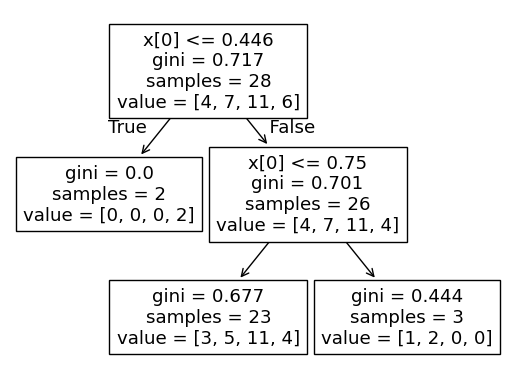

In [ ]:
tree_classifier = index_tree(redlining_ndvi_gdf)

# Visualize tree
plot_tree(tree_classifier)
plt.show()

In [ ]:
def plot_index_pred(redlining_ndvi_gdf, tree_classifier, city):
    """Plot the model results."""
    import hvplot.pandas # Interactive plots with pandas
    
    # Predict grades for each region
    redlining_ndvi_gdf ['predictions'] = (
        tree_classifier.predict(redlining_ndvi_gdf[['mean']]))

    # Subtract actual grades from predicted grades
    redlining_ndvi_gdf['error'] = (
        redlining_ndvi_gdf ['predictions'] - redlining_ndvi_gdf ['grade_codes'])

    # Plot the calculated prediction errors as a chloropleth
    pred_hv = redlining_ndvi_gdf.hvplot(
        c='error', geo=True,
        xaxis='Longitude', yaxis='Latitude',
        clabel='Predicted Grades Error',
        title = city + ' Calculated Prediction Errors')

    return pred_hv

# pred_hv = plot_treepred(redlining_ndvi_gdf, tree_classifier, city)

In [100]:
pred_hv = plot_treepred(redlining_ndvi_gdf, tree_classifier, city)
pred_hv

:Polygons   [Longitude,Latitude]   (error)

In [101]:
# Plot NDVI, predicted and redlining grade in linked subplots
madison_hv = (ndvi_hv + pred_hv + grade_hv)

# Save the linked plots as a file to put on the web
import holoviews as hv
hv.save(madison_hv, 'madison.html')

madison_hv

:Layout
   .Polygons.I   :Polygons   [Longitude,Latitude]   (mean)
   .Polygons.II  :Polygons   [Longitude,Latitude]   (error)
   .Polygons.III :Polygons   [Longitude,Latitude]   (grade)

## Evaluate the Model

In [59]:
# Evaluate the model with cross-validation
cross_val_score(
    DecisionTreeClassifier(max_depth=2),
    redlining_ndvi_gdf[['mean']],
    redlining_ndvi_gdf.grade_codes,
    cv=3
)

array([0.2       , 0.11111111, 0.11111111])

In [60]:
# Try another model - changing the hyperparameters
# Evaluate the model with cross-validation
cross_val_score(
    DecisionTreeClassifier(max_depth=4),
    redlining_ndvi_gdf[['mean']],
    redlining_ndvi_gdf.grade_codes,
    cv=3
)

array([0.3       , 0.11111111, 0.11111111])